In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
from sklearn.neighbors import KNeighborsClassifier
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset from the ../Data/Raw directory

In [4]:
df = pd.read_csv('../Data/Raw/steel.csv')

df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,2018-01-01 02:30:00,3.78,4.72,0.00,0.0,62.51,100.00,9000,Weekday,Monday
1,2018-01-01 04:15:00,3.28,3.82,0.00,0.0,65.14,100.00,15300,Weekday,Monday
2,2018-01-01 05:45:00,3.28,3.49,0.00,0.0,68.48,100.00,20700,Weekday,Monday
3,2018-01-01 10:00:00,3.64,0.00,16.88,0.0,100.00,21.08,36000,Weekday,Monday
4,2018-01-01 10:30:00,3.71,0.00,18.00,0.0,100.00,20.19,37800,Weekday,Monday


In [5]:
df.isnull().sum().sort_values(ascending=False)

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
dtype: int64

### Observation
- There are no missing values in the dataset

### One Hot Encoding

In [6]:
df = pd.get_dummies(df,columns=["WeekStatus","Day_of_week"], drop_first=True,dtype='int')
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday
0,2018-01-01 02:30:00,3.78,4.72,0.00,0.0,62.51,100.00,9000,0,1,0,0,0,0,0
1,2018-01-01 04:15:00,3.28,3.82,0.00,0.0,65.14,100.00,15300,0,1,0,0,0,0,0
2,2018-01-01 05:45:00,3.28,3.49,0.00,0.0,68.48,100.00,20700,0,1,0,0,0,0,0
3,2018-01-01 10:00:00,3.64,0.00,16.88,0.0,100.00,21.08,36000,0,1,0,0,0,0,0
4,2018-01-01 10:30:00,3.71,0.00,18.00,0.0,100.00,20.19,37800,0,1,0,0,0,0,0


### Convert data to support binary classification

In [7]:
usage_kwh_mean = df['Usage_kWh'].mean()
df['Usage_kWh_categorical'] = np.where(df['Usage_kWh'] <= usage_kwh_mean, 'Low', 'High')
df.drop(columns=['date'], inplace=True)

robust_scaler = RobustScaler()
df[["Usage_kWh","Lagging_Current_Reactive.Power_kVarh","Leading_Current_Reactive_Power_kVarh","Lagging_Current_Power_Factor","Leading_Current_Power_Factor","CO2(tCO2)"]] = robust_scaler.fit_transform(df[["Usage_kWh","Lagging_Current_Reactive.Power_kVarh","Leading_Current_Reactive_Power_kVarh","Lagging_Current_Power_Factor","Leading_Current_Power_Factor","CO2(tCO2)"]])

df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Usage_kWh_categorical
0,-0.017360,-0.014388,0.000000,0.0,-0.737075,0.000000,9000,0,1,0,0,0,0,0,Low
1,-0.027453,-0.054856,0.000000,0.0,-0.661852,0.000000,15300,0,1,0,0,0,0,0,Low
2,-0.027453,-0.069694,0.000000,0.0,-0.566321,0.000000,20700,0,1,0,0,0,0,0,Low
3,-0.020186,-0.226619,7.672727,0.0,0.335216,-328.833333,36000,0,1,0,0,0,0,0,Low
4,-0.018773,-0.226619,8.181818,0.0,0.335216,-332.541667,37800,0,1,0,0,0,0,0,Low


In [8]:
if 'Usage_kWh' in df.columns:
    df = df.drop(columns='Usage_kWh', axis=0)
if 'NSM' in df.columns:
    df = df.drop(columns='NSM', axis=0)    

df.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Usage_kWh_categorical
0,-0.014388,0.000000,0.0,-0.737075,0.000000,0,1,0,0,0,0,0,Low
1,-0.054856,0.000000,0.0,-0.661852,0.000000,0,1,0,0,0,0,0,Low
2,-0.069694,0.000000,0.0,-0.566321,0.000000,0,1,0,0,0,0,0,Low
3,-0.226619,7.672727,0.0,0.335216,-328.833333,0,1,0,0,0,0,0,Low
4,-0.226619,8.181818,0.0,0.335216,-332.541667,0,1,0,0,0,0,0,Low


### Data Preparation

- `Usage_kWh_categorical` column is converted to binary.

In [9]:
mapper = {'Low':0,'High':1}
df['Usage_kWh_categorical'] = df['Usage_kWh_categorical'].replace(mapper)
df['Usage_kWh_categorical'].value_counts()

Usage_kWh_categorical
0    1328
1     862
Name: count, dtype: int64

In [10]:
# Remove rows with missing values
df.dropna(inplace=True)

y = df['Usage_kWh_categorical']
X = df.drop('Usage_kWh_categorical', axis=1)

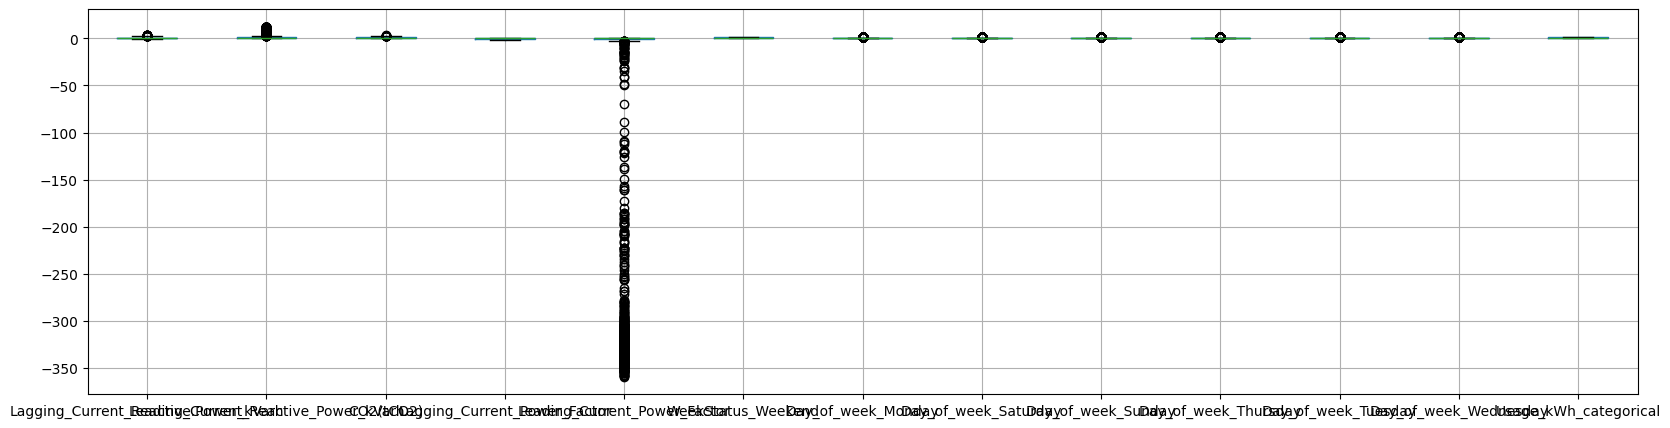

In [11]:

df.boxplot(figsize=(20, 5))
plt.show()

array([[<Axes: title={'center': 'Lagging_Current_Reactive.Power_kVarh'}>,
        <Axes: title={'center': 'Leading_Current_Reactive_Power_kVarh'}>,
        <Axes: title={'center': 'CO2(tCO2)'}>,
        <Axes: title={'center': 'Lagging_Current_Power_Factor'}>],
       [<Axes: title={'center': 'Leading_Current_Power_Factor'}>,
        <Axes: title={'center': 'WeekStatus_Weekend'}>,
        <Axes: title={'center': 'Day_of_week_Monday'}>,
        <Axes: title={'center': 'Day_of_week_Saturday'}>],
       [<Axes: title={'center': 'Day_of_week_Sunday'}>,
        <Axes: title={'center': 'Day_of_week_Thursday'}>,
        <Axes: title={'center': 'Day_of_week_Tuesday'}>,
        <Axes: title={'center': 'Day_of_week_Wednesday'}>],
       [<Axes: title={'center': 'Usage_kWh_categorical'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

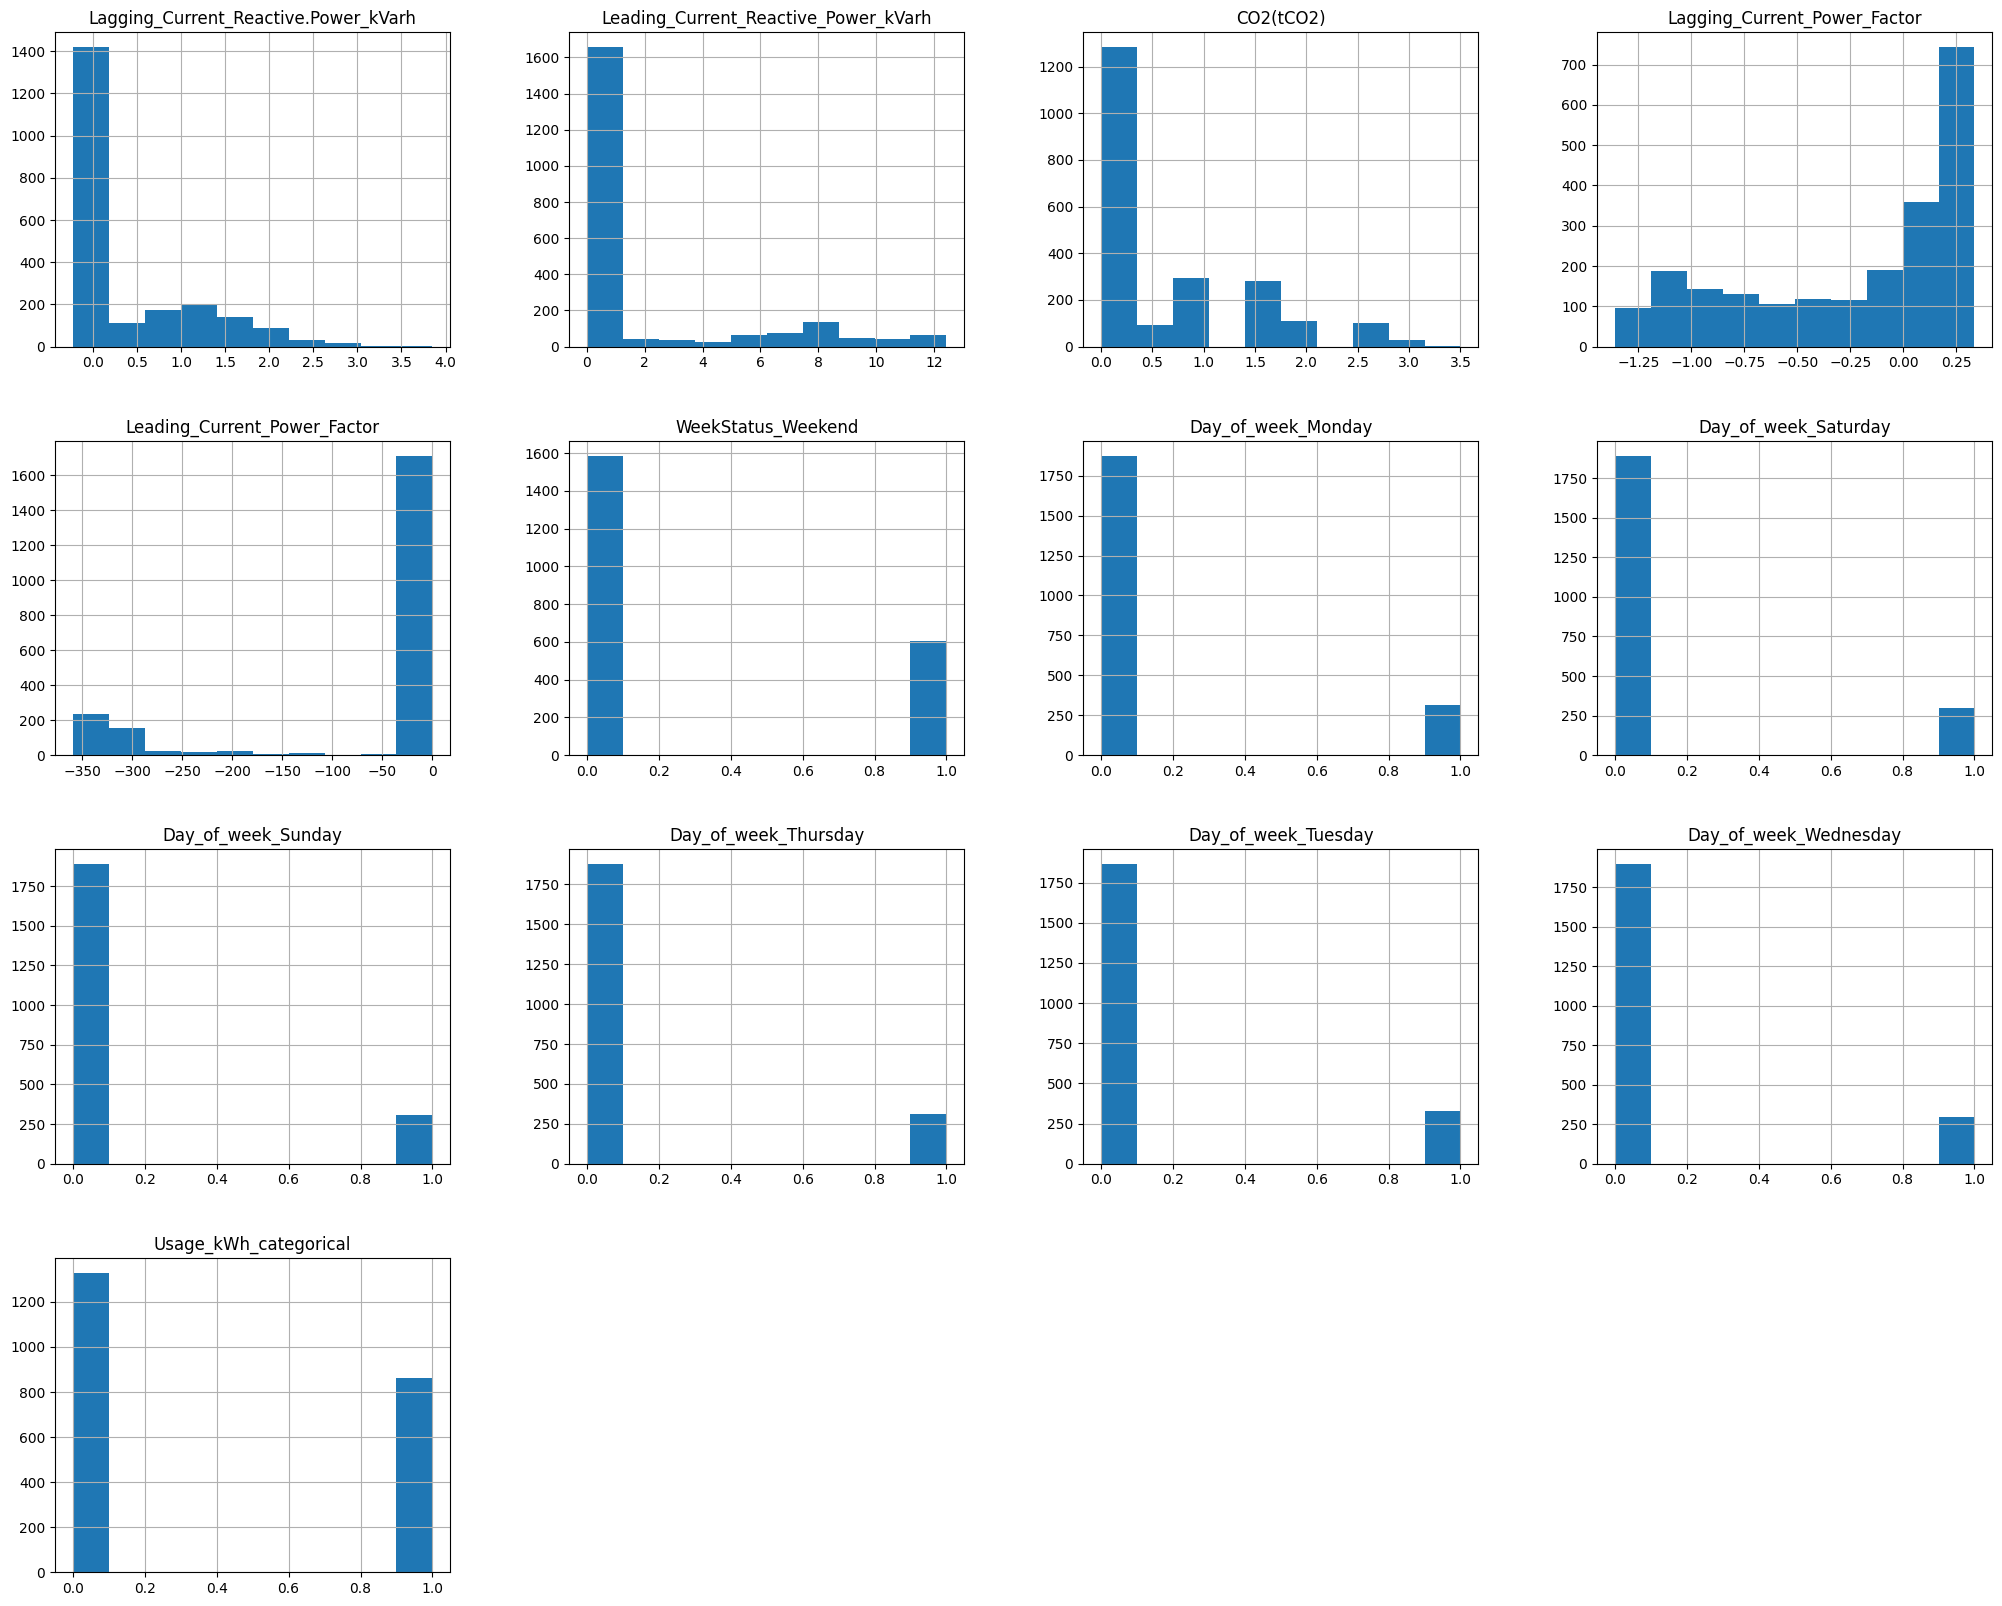

In [12]:
df.hist(bins=10, figsize=(25, 20))

In [13]:
columns_No_Outliers_skewed = ['Lagging_Current_Power_Factor']
columns_Outliers_skewed = ['CO2(tCO2)', 'WeekStatus_Weekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Leading_Current_Power_Factor', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh']


In [14]:
len(columns_No_Outliers_skewed) + len(columns_Outliers_skewed)  == X.shape[1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Lagging_Current_Reactive.Power_kVarh  2190 non-null   float64
 1   Leading_Current_Reactive_Power_kVarh  2190 non-null   float64
 2   CO2(tCO2)                             2190 non-null   float64
 3   Lagging_Current_Power_Factor          2190 non-null   float64
 4   Leading_Current_Power_Factor          2190 non-null   float64
 5   WeekStatus_Weekend                    2190 non-null   int64  
 6   Day_of_week_Monday                    2190 non-null   int64  
 7   Day_of_week_Saturday                  2190 non-null   int64  
 8   Day_of_week_Sunday                    2190 non-null   int64  
 9   Day_of_week_Thursday                  2190 non-null   int64  
 10  Day_of_week_Tuesday                   2190 non-null   int64  
 11  Day_of_week_Wedne

 ### Building the preprocessing pipeline by using Pipeline and ColumnTransformer as follows.

In [15]:
No_Outliers_skewed_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.cbrt)), 
        ("scaler", MinMaxScaler())
    ]
)

Outliers_skewed_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.cbrt)), 
        ("scaler", RobustScaler())
    ]
)



preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("No_Outliers_skewed", No_Outliers_skewed_pipeline, columns_No_Outliers_skewed),    
        ("Outliers_skewed", Outliers_skewed_pipeline, columns_Outliers_skewed),
        
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

### Spliting the dataset into a training and test sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Model Training

### SVM

In [17]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [18]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('No_Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Lagging_Current_Power_Factor']),
                                                 ('Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['CO2(tCO2)',
                                                   'WeekStatus_Weekend',
                                                   'Day_of_week_Monday',
                                                   'Day_of_week_Saturday',
                                                   'Day_of_week_Sunday',
                                                   'Day_of_week_Thursday',
                                                   'Day_of_week_Tuesday',
                                                   'Day_of_week_Wednesday',
                                                   'Leading_Current_Power_Factor',
                                                   'Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh'])])),
                ('svm', SVC(probability=True))])

In [19]:
 #prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.989:
Best parameters:  {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'poly'}


### Random Forest

In [20]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

In [21]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('No_Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Lagging_Current_Power_Factor']),
                                                 ('Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['CO2(tCO2)',
                                                   'WeekStatus_Weekend',
                                                   'Day_of_week_Monday',
                                                   'Day_of_week_Saturday',
                                                   'Day_of_week_Sunday',
                                                   'Day_of_week_Thursday',
                                                   'Day_of_week_Tuesday',
                                                   'Day_of_week_Wednesday',
                                                   'Leading_Current_Power_Factor',
                                                   'Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh'])])),
                ('rf', RandomForestClassifier())])

In [22]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 10}


### KNN

In [23]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [24]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('No_Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Lagging_Current_Power_Factor']),
                                                 ('Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['CO2(tCO2)',
                                                   'WeekStatus_Weekend',
                                                   'Day_of_week_Monday',
                                                   'Day_of_week_Saturday',
                                                   'Day_of_week_Sunday',
                                                   'Day_of_week_Thursday',
                                                   'Day_of_week_Tuesday',
                                                   'Day_of_week_Wednesday',
                                                   'Leading_Current_Power_Factor',
                                                   'Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh'])])),
                ('knn', KNeighborsClassifier(n_jobs=-1))])

In [25]:
param_grid = {
    'knn__n_neighbors' : [3,5,10,15,20],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'knn__weights': ['uniform', 'distance']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.986:
Best parameters:  {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 10, 'knn__weights': 'uniform'}


### MLP classifier

In [26]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier())])

In [27]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('No_Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Lagging_Current_Power_Factor']),
                                                 ('Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['CO2(tCO2)',
                                                   'WeekStatus_Weekend',
                                                   'Day_of_week_Monday',
                                                   'Day_of_week_Saturday',
                                                   'Day_of_week_Sunday',
                                                   'Day_of_week_Thursday',
                                                   'Day_of_week_Tuesday',
                                                   'Day_of_week_Wednesday',
                                                   'Leading_Current_Power_Factor',
                                                   'Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh'])])),
                ('mlp', MLPClassifier())])

In [28]:
param_grid = {
    'mlp__learning_rate_init' : [0.001,0.01,0.1],
    'mlp__max_iter': [200, 300, 400],
    'mlp__activation': ['logistic', 'relu']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Best CV score = 0.987:
Best parameters:  {'mlp__activation': 'relu', 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 300}


### Naive Bayes Classifier

In [29]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('nb', GaussianNB())])

In [30]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('No_Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Lagging_Current_Power_Factor']),
                                                 ('Outliers_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['CO2(tCO2)',
                                                   'WeekStatus_Weekend',
                                                   'Day_of_week_Monday',
                                                   'Day_of_week_Saturday',
                                                   'Day_of_week_Sunday',
                                                   'Day_of_week_Thursday',
                                                   'Day_of_week_Tuesday',
                                                   'Day_of_week_Wednesday',
                                                   'Leading_Current_Power_Factor',
                                                   'Lagging_Current_Reactive.Power_kVarh',
                                                   'Leading_Current_Reactive_Power_kVarh'])])),
                ('nb', GaussianNB())])

In [31]:
param_grid = {
    
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
NB_best_params = search.best_params_
NB_best_model = search.best_estimator_

Best CV score = 0.979:
Best parameters:  {}


### Models Evaluation
The evaluation metrics are:
    - accuracy
    - precisions
    - recall
    - F1-score
    - TPR (true positive rate)
    - AUC (area under the ROC curve)

In [32]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [33]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [34]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)
NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = evaluate_model(X_test, y_test, NB_best_model)

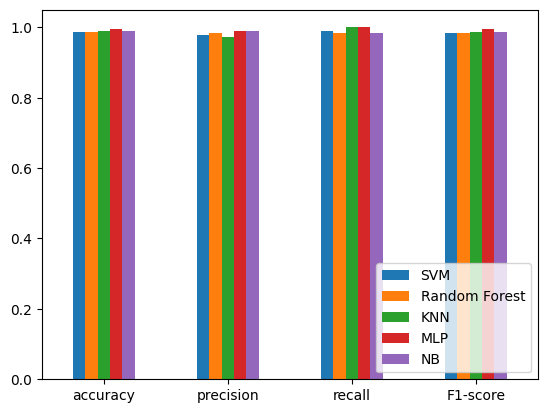

In [35]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics, 'MLP': MLP_metrics, 'NB': NB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

While all classifiers function well, Random forest performs the best. The outcomes will be a little different if you run this notebook again. An ideal improvement for the code would be to repeat the entire experiment several times, averaging the outcomes.

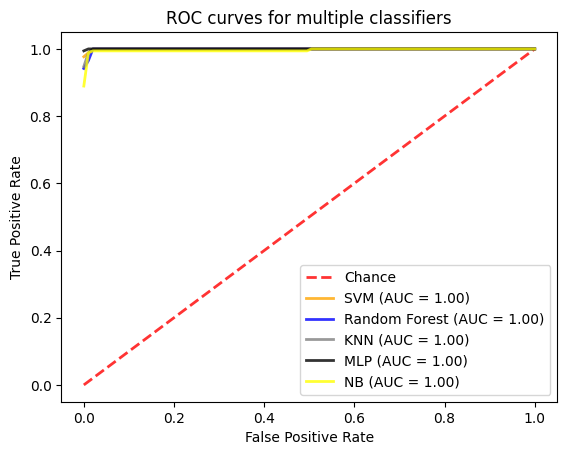

In [36]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='orange', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='blue', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='grey', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='black', label='MLP (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.plot(mean_fpr, NB_tpr[0,:], lw=2, color='yellow', label='NB (AUC = %0.2f)' % (KNN_auc), alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed `no skill` line). 

### Training the Final Model

In [37]:
# function to remove the string 'rf__' from the names of the parameters in RF_best_params
def transform(dict):
    return {key.replace('rf__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(**transform(RF_best_params)))

final_model = pipe.fit(X_train, y_train)

final_model.score(X_test, y_test)

0.9931506849315068

### Saving the trained model in Models directory

In [38]:
filename = 'final_RF_classifier_model.sav'
pickle.dump(final_model, open(f'../Models/{filename}', 'wb'))